In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, brier_score_loss, make_scorer
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import os
from ehr_utils import *

In [2]:
output_dir = "/home/blhill/paper"
pred_probs_f = "model_pred_probs.txt"

dnn_pred_probs_f = "/home/nrakocz/EhrMain/predictions_proba.csv"
# files with predicted probability of death for each input feature set
# cols should look like: ADMSN_ID INPT_DEATH_YN PRED_DEATH_ELASTICNET PRED_DEATH_LOGREG PRED_DEATH_RF PRED_DEATH_XGB
onlyASA_probs_f = os.path.join(output_dir, os.path.join("asa", pred_probs_f))
preopASA_probs_f = os.path.join(output_dir, os.path.join("preop_asa", pred_probs_f))
predASA_probs_f = os.path.join(output_dir, os.path.join("preop_imp_asa", pred_probs_f))
charlson_probs_f = os.path.join(output_dir, os.path.join("charlson", pred_probs_f))
preop_probs_f = os.path.join(output_dir, os.path.join("preop", pred_probs_f))

preopASA_probs_notime_f = os.path.join(output_dir, os.path.join("preop_asa_no_lab_times", pred_probs_f))
predASA_probs_notime_f = os.path.join(output_dir, os.path.join("preop_imp_asa_no_lab_times", pred_probs_f))
preop_probs_notime_f = os.path.join(output_dir, os.path.join("preop_no_lab_times", pred_probs_f))

In [3]:
# read data into pandas data frame
onlyASA_df = pd.read_csv(onlyASA_probs_f, sep="\t", header=0)
preopASA_df = pd.read_csv(preopASA_probs_f, sep="\t", header=0)
predASA_df = pd.read_csv(predASA_probs_f, sep="\t", header=0)
charlson_df = pd.read_csv(charlson_probs_f, sep="\t", header=0)
preop_df = pd.read_csv(preop_probs_f, sep="\t", header=0)

preopASA_notime_df = pd.read_csv(preopASA_probs_notime_f, sep="\t", header=0)
predASA_notime_df = pd.read_csv(predASA_probs_notime_f, sep="\t", header=0)
preop_notime_df = pd.read_csv(preop_probs_notime_f, sep="\t", header=0)

dnn_df = pd.read_csv(dnn_pred_probs_f, sep=",", header=0)

In [4]:
# group predictions by model type
y_true = []
log_reg_preds = []
elasticnet_preds = []
random_forest_preds = []
xgb_preds = []
dnn_preds = []

dfs = [charlson_df, onlyASA_df, preop_df, preopASA_df, predASA_df, preop_notime_df, preopASA_notime_df, predASA_notime_df]
dataset_names = ["Charlson", "ASA Status", "Preop", "Preop + ASA", "Preop + Imputed ASA", "Preop (no lab times)", "Preop + ASA (no lab times)", "Preop + Imputed ASA (no lab times)"]
#dfs = [charlson_df, onlyASA_df, preop_df, preopASA_df, preop_notime_df, preopASA_notime_df]
#dataset_names = ["Charlson", "ASA Status", "Preop", "Preop + ASA", "Preop (no lab times)", "Preop + ASA (no lab times)"]

dnn_dataset_names = ["non_mortal_predict_proba_charlson", "non_mortal_predict_proba_asa", "non_mortal_predict_proba_preop",
                     "non_mortal_predict_proba_preop_asa", "non_mortal_predict_proba_preop_imp_asa",
                     "non_mortal_predict_proba_preop_no_lab_times", "non_mortal_predict_proba_preop_asa_no_lab_times",
                    "non_mortal_predict_proba_preop_imp_asa_no_lab_times"]


    
# hack to make probability inputs match format of sklearn model output
for i in range(len(dfs)):
    d = dfs[i].merge(dnn_df, on="OR_CASE_ID", how="inner")
    y_true.append(d["INPT_DEATH_YN"])
    log_reg_preds.append(np.array([[-1,x] for x in d["Log. Regression"]]))
    elasticnet_preds.append(np.array([[-1,x] for x in d["ElasticNet"]]))
    random_forest_preds.append(np.array([[-1,x] for x in d["Random Forest"]]))
    xgb_preds.append(np.array([[-1,x] for x in d["XGBClassifier"]]))
    dnn_preds.append(np.array([[-1,1. - x] for x in d[dnn_dataset_names[i]]]))

/home/blhill/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


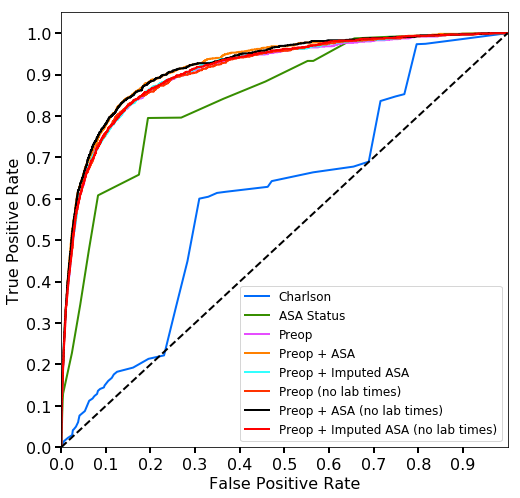

Logistic Regression
Charlson 		0.1992508041622547
ASA Status 		0.07975260236749311
Preop 		0.0563822550100058
Preop + ASA 		0.05228589720068973
Preop + Imputed ASA 		0.05601729556575821
Preop (no lab times) 		0.05789815989400454
Preop + ASA (no lab times) 		0.05336740188977362
Preop + Imputed ASA (no lab times) 		0.05769987217602412


In [7]:
plot_roc_curve(dataset_names, dataset_names, log_reg_preds, y_true, os.path.join(output_dir, "log_reg_roc.tif"))
print("Logistic Regression")
for i in range(len(dataset_names)):
    brier_loss = brier_score_loss(y_true[i], log_reg_preds[i][:,1])
    print dataset_names[i],"\t\t", brier_loss

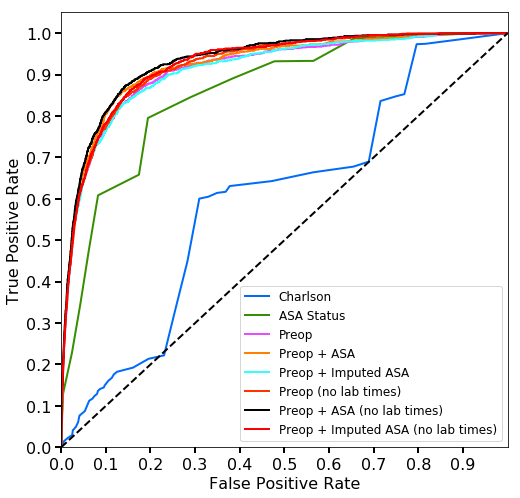

ElasticNet
Charlson 		0.1993214541568832
ASA Status 		0.0794893675212643
Preop 		0.05724493499566782
Preop + ASA 		0.05200892766097836
Preop + Imputed ASA 		0.05647555955894389
Preop (no lab times) 		0.05861428587758905
Preop + ASA (no lab times) 		0.053624760727187186
Preop + Imputed ASA (no lab times) 		0.05859999500044855


In [8]:
plot_roc_curve(dataset_names, dataset_names, elasticnet_preds, y_true, os.path.join(output_dir, "elasticnet_roc.tif"))
print("ElasticNet")
for i in range(len(dataset_names)):
    brier_loss = brier_score_loss(y_true[i], elasticnet_preds[i][:,1])
    print dataset_names[i],"\t\t", brier_loss

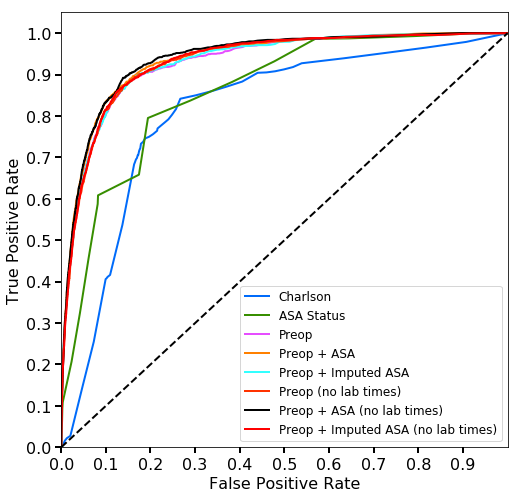

Random Forest
Charlson 		0.09340279489030383
ASA Status 		0.08108366615272254
Preop 		0.017952490499011365
Preop + ASA 		0.01737166202369382
Preop + Imputed ASA 		0.01795334234139884
Preop (no lab times) 		0.017702418290659872
Preop + ASA (no lab times) 		0.017031955289218807
Preop + Imputed ASA (no lab times) 		0.017765925181809042


In [9]:
plot_roc_curve(dataset_names, dataset_names, random_forest_preds, y_true, os.path.join(output_dir, "random_forest_roc.tif"))
print("Random Forest")
for i in range(len(dataset_names)):
    brier_loss = brier_score_loss(y_true[i], random_forest_preds[i][:,1])
    print dataset_names[i],"\t\t", brier_loss

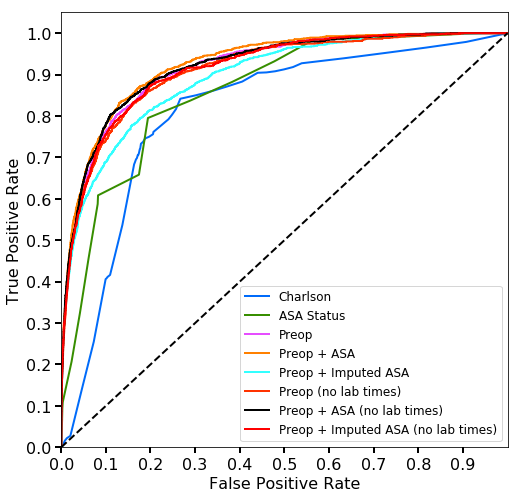

XGBoost
Charlson 		0.09340425295570401
ASA Status 		0.0810826624335102
Preop 		0.015615997096928135
Preop + ASA 		0.015465037635023417
Preop + Imputed ASA 		0.015693935228681545
Preop (no lab times) 		0.015814534687831026
Preop + ASA (no lab times) 		0.015700979359825194
Preop + Imputed ASA (no lab times) 		0.01558199897192218


In [10]:
plot_roc_curve(dataset_names, dataset_names, xgb_preds, y_true, os.path.join(output_dir, "xgboost_roc.tif"))
print("XGBoost")
for i in range(len(dataset_names)):
    brier_loss = brier_score_loss(y_true[i], xgb_preds[i][:,1])
    print dataset_names[i],"\t\t", brier_loss

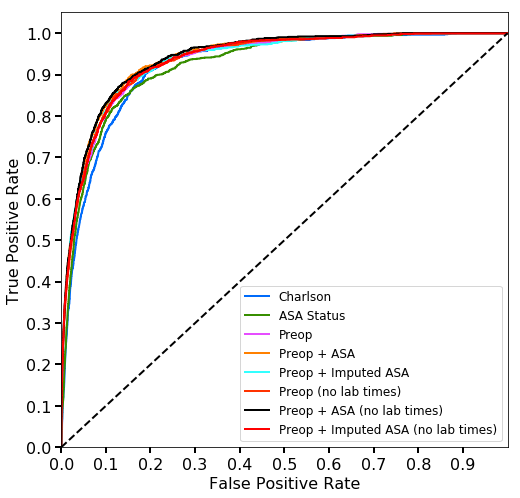

DNN


In [11]:
plot_roc_curve(dataset_names, dataset_names, dnn_preds, y_true, os.path.join(output_dir, "dnn_roc.tif"))
print("DNN")

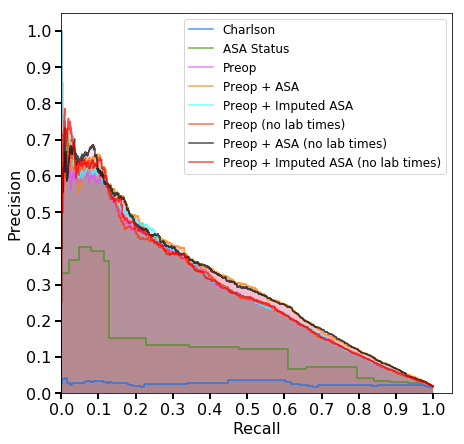

Logistic Regression


In [12]:
plot_precision_recall_curve(dataset_names, dataset_names, log_reg_preds, y_true, os.path.join(output_dir, "log_reg_pr.tif"))
print("Logistic Regression")

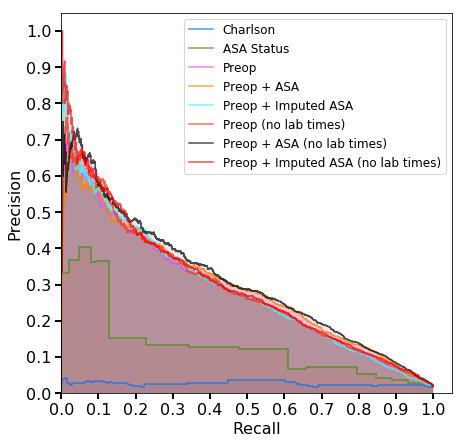

ElasticNet


In [13]:
plot_precision_recall_curve(dataset_names, dataset_names, elasticnet_preds, y_true, os.path.join(output_dir, "elasticnet_pr.tif"))
print("ElasticNet")

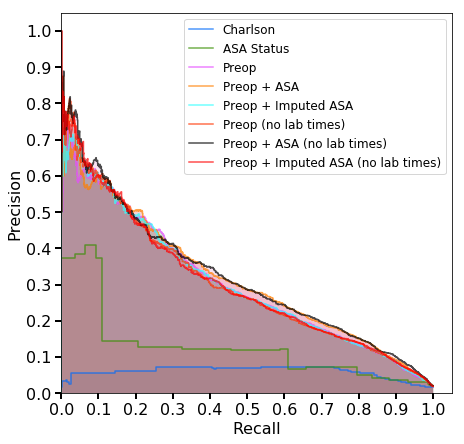

Random Forest


In [14]:
plot_precision_recall_curve(dataset_names, dataset_names, random_forest_preds, y_true, os.path.join(output_dir, "random_forest_pr.tif"))
print("Random Forest")

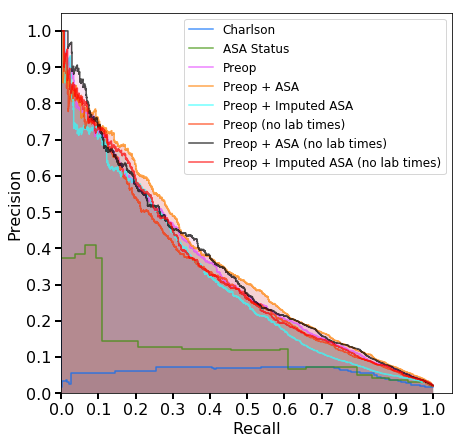

XGBoost


In [15]:
plot_precision_recall_curve(dataset_names, dataset_names, xgb_preds, y_true, os.path.join(output_dir, "xgboost_pr.tif"))
print("XGBoost")

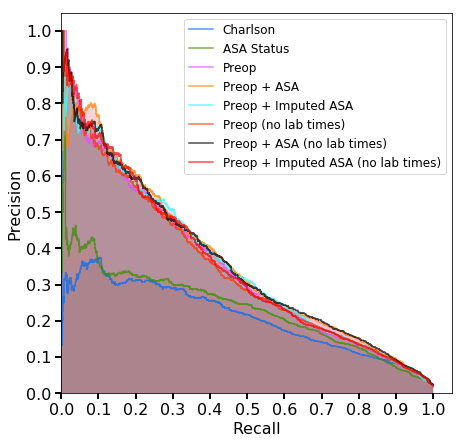

DNN


In [16]:
plot_precision_recall_curve(dataset_names, dataset_names, dnn_preds, y_true, os.path.join(output_dir, "dnn_pr.tif"))
print("DNN")